In [3]:
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

In [4]:
df = pd.read_csv('stock_price.csv')
df.head()

,close,datetime,high,low,open,symbol,volume
0,105.51,1513144800000,107.11,105.48,106.70,JPM,15020293
1,104.66,1513231200000,106.45,104.64,106.12,JPM,13034232
2,106.14,1513317600000,106.52,105.20,105.79,JPM,29350598
3,106.96,1513576800000,107.63,106.48,107.19,JPM,12713148
4,106.51,1513663200000,107.49,106.44,107.35,JPM,12149937


In [5]:
#reorganize the data
df = df[['symbol', 'datetime', 'close','high','low','open', 'volume']]


#sort the dataon symbol and datetime
df.sort_values(by = ['symbol','datetime'], inplace=True)

#change in price
df['change_close'] = df['close'].diff()
df

,symbol,datetime,close,high,low,open,volume,change_close
2016,ARWR,1513144800000,3.40,3.410,3.0100,3.30,2037395,NaN
2017,ARWR,1513231200000,3.15,3.420,3.0500,3.41,1702102,-0.25
2018,ARWR,1513317600000,3.14,3.200,3.0800,3.19,1305646,-0.01
2019,ARWR,1513576800000,3.23,3.395,3.1400,3.15,1254305,0.09
2020,ARWR,1513663200000,3.26,3.380,3.2271,3.25,1128590,0.03
...,...,...,...,...,...,...,...,...
499,JPM,1575871200000,134.41,135.460,134.4100,134.63,8576380,-0.63
500,JPM,1575957600000,134.50,134.770,132.8800,133.25,7533000,0.09
501,JPM,1576044000000,134.18,135.020,134.0100,134.29,9012476,-0.32
502,JPM,1576130400000,138.02,138.470,134.2100,134.49,13725737,3.84


In [6]:
#identify rows where symbol changes
mask = df['symbol'] != df['symbol'].shift(1)
mask

#for that rows make the value null
df['chang_close'] = np.where(mask == True, np.nan, df['change_close'] )
df

#print the rows that have null value
df[df.isna().any(axis='columns')]

,symbol,datetime,close,high,low,open,volume,change_close,chang_close
2016,ARWR,1513144800000,3.40,3.41,3.01,3.30,2037395,NaN,NaN
504,COST,1513144800000,188.28,190.12,187.80,188.53,3062856,121.82,NaN
1512,HD,1513144800000,183.03,183.67,182.00,182.01,5177363,-108.84,NaN
1008,IBM,1513144800000,153.91,156.73,153.89,156.60,5661618,-60.17,NaN
0,JPM,1513144800000,105.51,107.11,105.48,106.70,15020293,-28.70,NaN


In [7]:
#calculate the 14 day RSI
n =14

#first make the copy of data twice
up_df, down_df = df[['symbol','change_close']].copy(), df[['symbol','change_close']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_close'] = up_df.loc[(up_df['change_close'] < 0), 'change_close'] = 0
up_df

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_close'] = down_df.loc[(down_df['change_close'] > 0), 'change_close'] = 0

down_df['change_close'] = down_df['change_close'].abs()


# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_close'].transform(lambda x: x.ewm(span=n).mean())
ewma_down = down_df.groupby('symbol')['change_close'].transform(lambda x: x.ewm(span=n).mean())

#Calculate Relative Strength
relative_strength = ewma_up/ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
df['down_days'] = down_df['change_close']
df['up_days'] = up_df['change_close']
df['RSI'] = relative_strength_index

df.head(10)

,symbol,datetime,close,high,low,open,volume,change_close,chang_close,down_days,up_days,RSI
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,-0.25,0.25,0.00,0.000000
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,-0.01,0.01,0.00,0.000000
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.09,0.00,0.09,31.419705
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.03,0.00,0.03,38.813758
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.17,0.00,0.17,64.112604
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,-0.05,0.05,0.00,56.223402
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.33,0.00,0.33,77.400849
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.08,0.00,0.08,80.094431
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.05,0.00,0.05,81.669970


In [8]:
#calculate the 14 day Stochastic Oscilaator
n =14

#first make the copy of high and low column
low_14 ,high_14 = df[['symbol','low']].copy(), df[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((df['close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
df['low_14'] = low_14
df['high_14'] = high_14
df['k_percent'] = k_percent

# Display the head.
df.head(10)

,symbol,datetime,close,high,low,open,volume,change_close,chang_close,down_days,up_days,RSI,low_14,high_14,k_percent
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.09,0.00,0.09,31.419705,NaN,NaN,NaN
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.03,0.00,0.03,38.813758,NaN,NaN,NaN
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.17,0.00,0.17,64.112604,NaN,NaN,NaN
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.33,0.00,0.33,77.400849,NaN,NaN,NaN
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.08,0.00,0.08,80.094431,NaN,NaN,NaN
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.05,0.00,0.05,81.669970,NaN,NaN,NaN


In [9]:
#calculate the 14 day Williams %R
n =14

#first make the copy of high and low column
low_14 ,high_14 = df[['symbol','low']].copy(), df[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
r_percent = 100 * ((df['close'] - high_14) / (high_14 - low_14))

# Add the info to the data frame.
df['low_14'] = low_14
df['high_14'] = high_14
df['r_percent'] = r_percent

# Display the head.
df.head(20)


,symbol,datetime,close,high,low,open,volume,change_close,chang_close,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN


In [10]:
# Calculate the MACD
ema_26 = df.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = df.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())

macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
df['MACD'] = macd
df['MACD_EMA'] = ema_9_macd

# Print the head.
df.head(30)

,symbol,datetime,close,high,low,open,volume,change_close,chang_close,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN,-0.005609,-0.003116
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN,-0.007457,-0.004895
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN,-0.004865,-0.004885
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN,-0.002161,-0.004075
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN,0.006775,-0.001134
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN,0.010123,0.001715
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN,0.027901,0.008008
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN,0.043756,0.016266
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN,0.056942,0.025380


In [11]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
df['Price_Rate_Of_Change'] = df.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
df.head(30)

,symbol,datetime,close,high,low,open,volume,change_close,chang_close,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN,-0.005609,-0.003116,NaN
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN,-0.007457,-0.004895,NaN
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN,-0.004865,-0.004885,NaN
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN,-0.002161,-0.004075,NaN
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN,0.006775,-0.001134,NaN
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN,0.010123,0.001715,NaN
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN,0.027901,0.008008,NaN
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN,0.043756,0.016266,NaN
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN,0.056942,0.025380,0.129412


In [16]:
closed_groups = df.groupby('symbol')['close']


closed_groups = closed_groups.transform(lambda x: x.shift(1) < x)
df['Prediction'] = closed_groups*1
df

,symbol,datetime,close,high,low,open,volume,change_close,chang_close,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
2029,ARWR,1514959200000,4.64,4.88,3.770,3.79,5875479,0.92,0.92,0.00,0.92,82.451324,3.0100,4.88,87.165775,-12.834225,0.114979,0.061321,0.423313,0
2030,ARWR,1515045600000,4.85,5.13,4.500,4.58,3402024,0.21,0.21,0.00,0.21,84.742603,3.0500,5.13,86.538462,-13.461538,0.164049,0.082616,0.413994,1
2031,ARWR,1515132000000,4.87,5.23,4.660,4.86,2278246,0.02,0.02,0.00,0.02,84.958420,3.0800,5.23,83.255814,-16.744186,0.200433,0.106862,0.440828,1
2032,ARWR,1515391200000,4.55,4.90,4.370,4.88,2659533,-0.32,-0.32,0.32,0.00,67.366376,3.1400,5.23,67.464115,-32.535885,0.205891,0.127124,0.226415,0
2033,ARWR,1515477600000,4.62,4.90,4.455,4.58,1430439,0.07,0.07,0.00,0.07,68.987239,3.2271,5.23,69.544161,-30.455839,0.211957,0.144402,0.218997,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,JPM,1575871200000,134.41,135.46,134.410,134.63,8576380,-0.63,-0.63,0.63,0.00,69.746792,128.5850,135.78,80.958999,-19.041001,2.155862,2.141347,0.022207,0
500,JPM,1575957600000,134.50,134.77,132.880,133.25,7533000,0.09,0.09,0.00,0.09,70.167070,128.5850,135.78,82.209868,-17.790132,2.180852,2.149248,0.021493,1
501,JPM,1576044000000,134.18,135.02,134.010,134.29,9012476,-0.32,-0.32,0.32,0.00,66.383667,128.5850,135.78,77.762335,-22.237665,2.150051,2.149408,0.016053,0
502,JPM,1576130400000,138.02,138.47,134.210,134.49,13725737,3.84,3.84,0.00,3.84,80.753092,128.5850,138.47,95.447648,-4.552352,2.407741,2.201075,0.047511,1


In [17]:
print('Before NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))

# Any row that has a `NaN` value will be dropped.
df = df.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))

# Print the head.
df.head()

Before NaN Drop we have 2455 rows and 20 columns
After NaN Drop we have 2455 rows and 20 columns


,symbol,datetime,close,high,low,open,volume,change_close,chang_close,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
2029,ARWR,1514959200000,4.64,4.88,3.770,3.79,5875479,0.92,0.92,0.00,0.92,82.451324,3.0100,4.88,87.165775,-12.834225,0.114979,0.061321,0.423313,0
2030,ARWR,1515045600000,4.85,5.13,4.500,4.58,3402024,0.21,0.21,0.00,0.21,84.742603,3.0500,5.13,86.538462,-13.461538,0.164049,0.082616,0.413994,1
2031,ARWR,1515132000000,4.87,5.23,4.660,4.86,2278246,0.02,0.02,0.00,0.02,84.958420,3.0800,5.23,83.255814,-16.744186,0.200433,0.106862,0.440828,1
2032,ARWR,1515391200000,4.55,4.90,4.370,4.88,2659533,-0.32,-0.32,0.32,0.00,67.366376,3.1400,5.23,67.464115,-32.535885,0.205891,0.127124,0.226415,0
2033,ARWR,1515477600000,4.62,4.90,4.455,4.58,1430439,0.07,0.07,0.00,0.07,68.987239,3.2271,5.23,69.544161,-30.455839,0.211957,0.144402,0.218997,1


In [19]:
X = df[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD']]
y = df['Prediction']


In [20]:
X_train,X_test, y_train , y_test = train_test_split(X , y ,random_state = 0)


In [21]:
model = RandomForestClassifier(n_estimators=100,
    criterion='gini',random_state=0,oob_score=True)

In [22]:
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [23]:
model.score(X_test,y_test)

0.7263843648208469

In [24]:
pred = model.predict(X_test)
pred

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,

In [110]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, pred, normalize = True) * 100.0)


Correct Prediction (%):  72.63843648208469


Accuracy: 0.7263843648208469
Percision: 0.7366771159874608
Recall: 0.7366771159874608
Specificity: 0.7152542372881356


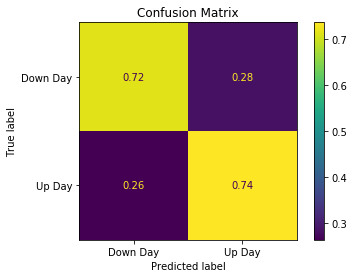

In [36]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
rf_matrix = confusion_matrix(y_test,pred)
rf_matrix

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[0][1]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[1][0]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)


print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(model , X_test, y_test,display_labels = ['Down Day', 'Up Day'],normalize ='true')
disp.ax_.set_title('Confusion Matrix')
plt.show()

In [42]:
#Calculate feature importances and store in pandas Series
feature_imp = pd.Series(model.feature_importances_, index = X.columns).sort_values(ascending =False)
feature_imp


k_percent               0.221189
r_percent               0.215766
RSI                     0.196941
MACD                    0.188411
Price_Rate_Of_Change    0.177693
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

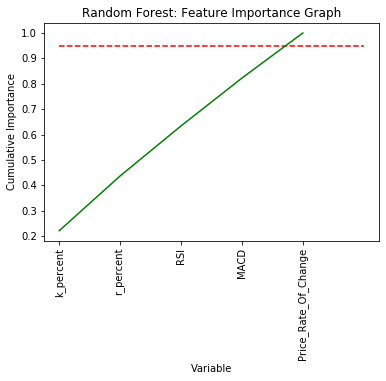

In [63]:
#store vlaues in list to plot
x_values = list(range(len(model.feature_importances_)))
x_values

#CUMILATIVE IMPORTANCE
cumilative_importances = np.cumsum(feature_imp.values)
cumilative_importances

#Make a line graph
plt.plot(x_values,cumilative_importances, 'g-')

#Format cticks and xlabels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95 , xmin = 0, xmax = len(feature_imp),color ='r',linestyles= 'dashed')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')